In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

from detector_layers import ApplyAsymmetricJitter

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

In [31]:
pscale = .375  # arcsec/pixel
det_npix = 128
oversample = 4
wf_npixels = 512
kernel_size = 20
jitter_params = {"r": 1, "phi": 80, "shear": 0.8}

In [32]:
src = dlT.AlphaCen()
osys = dlT.TolimanOptics(wf_npixels=512, psf_pixel_scale=pscale, psf_oversample=oversample, psf_npixels=det_npix*oversample)
det = dl.LayeredDetector([
    (ApplyAsymmetricJitter(**jitter_params, kernel_size=kernel_size), 'Jitter'),
    (dl.IntegerDownsample(oversample), 'Downsample'),
])

telescope = dl.Instrument(sources=src, optics=osys, detector=det)

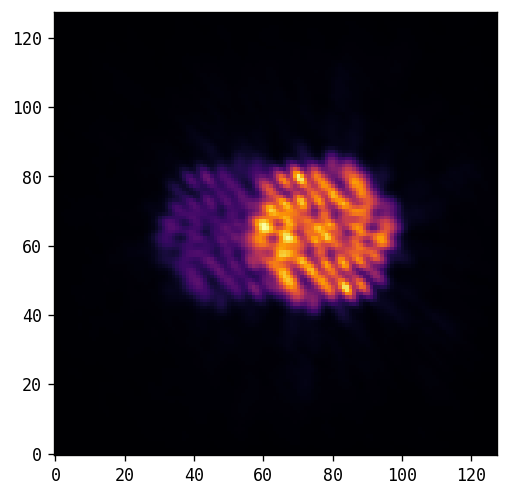

In [33]:
plt.imshow(telescope.model())

In [10]:
from jax import vmap

# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
]
# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike)

# Bar sizes
rs = np.linspace(0.01, 1, 10)
shears = np.array([0, 0.99, 10])

covs, seps, pas, xs, ys, fluxes, conts = [], [], [], [], [], [], []
for r in tqdm(rs):
    # Set mask width
    model = telescope.set("detector.Jitter.r", r)

    # Calculate covariance matrix and standard deviations
    cov = calc_cov(model, params)
    
    covs.append(cov)

    stds = np.sqrt(np.diag(np.abs(cov)))

    # Save values
    seps.append(stds[0])
    pas.append(stds[1])
    xs.append(stds[2])
    ys.append(stds[3])
    fluxes.append(stds[4])
    conts.append(stds[5])

seps = np.array(seps)
pas = np.array(pas)
xs = np.array(xs)
ys = np.array(ys)
fluxes = np.array(fluxes)
conts = np.array(conts)

covs = np.array(covs)
ents = vmap(zdx.covaraince_entropy)(covs)

  0%|          | 0/15 [00:00<?, ?it/s]

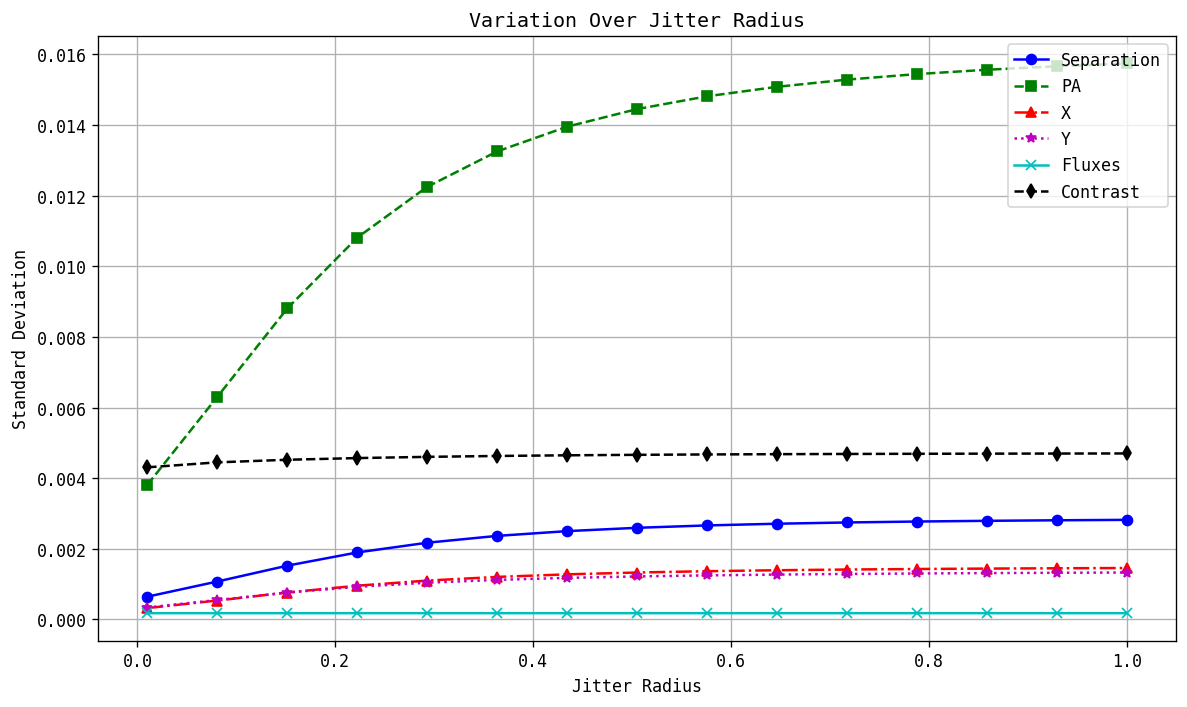

In [17]:
plt.figure(figsize=(10, 6))  # Adjust figure size for clarity
plt.plot(rs, seps, label='Separation', marker='o', linestyle='-', color='b')
plt.plot(rs, pas, label='PA', marker='s', linestyle='--', color='g')
plt.plot(rs, xs, label='X', marker='^', linestyle='-.', color='r')
plt.plot(rs, ys, label='Y', marker='*', linestyle=':', color='m')
plt.plot(rs, fluxes, label='Fluxes', marker='x', linestyle='-', color='c')
plt.plot(rs, conts, label='Contrast', marker='d', linestyle='--', color='k')

plt.xlabel('Jitter Radius')
plt.ylabel('Standard Deviation')
plt.title('Variation Over Jitter Radius')  # Add a title
plt.grid(True)  # Add a grid for better readability
plt.legend(loc='upper right')  # Add a legend with position
plt.tight_layout()  # Ensure all elements are within the plot area

plt.show()

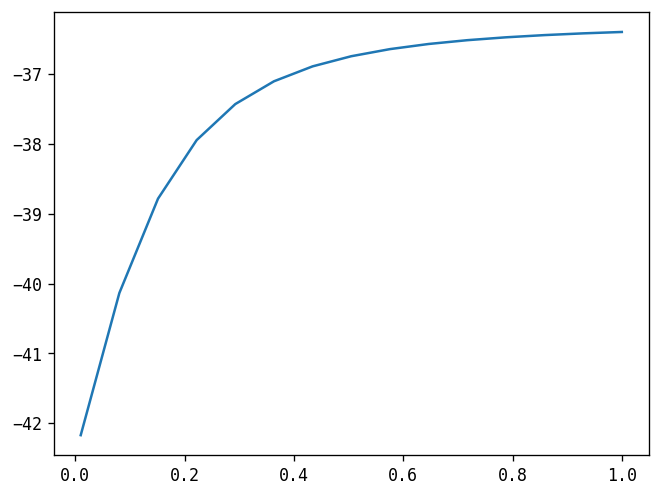

In [20]:
plt.plot(rs, ents)